In [1]:
import json
import time
from pathlib import Path

import numpy as np
import qibo
from qibo import hamiltonians, set_backend
from boostvqe.models.dbi.double_bracket import (
    DoubleBracketGeneratorType,
    DoubleBracketIteration,
)
from boostvqe.models.dbi.utils import *
from boostvqe.models.dbi.utils_scheduling import *
from boostvqe.models.dbi.utils_dbr_strategies import *

from boostvqe.ansatze import VQE, build_circuit
from boostvqe.utils import apply_dbi_steps, rotate_h_with_vqe
from qibo import symbols, hamiltonians
from copy import deepcopy
from boostvqe.compiling_XXZ import *

import matplotlib.pyplot as plt

In [2]:
def initialize_dbi(nqubits, model, param):
    if model == "XXZ":
        hamiltonian = hamiltonians.XXZ(nqubits=nqubits, delta=param)
    if model == "TFIM":
        hamiltonian = hamiltonians.TFIM(nqubits=nqubits, h=param)
    dbi = DoubleBracketIteration(hamiltonian=hamiltonian)
    return dbi

In [3]:
dbi = initialize_dbi(5, "TFIM", 3)
dbi.cost = DoubleBracketCostFunction.off_diagonal_norm

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
[Qibo 0.2.9|INFO|2024-07-15 11:16:47]: Using qibojit (numba) backend on /CPU:0
INFO:qibo.config:Using qibojit (numba) backend on /CPU:0


In [4]:
s_space = np.linspace(1e-4,0.1,100)

Plot the norm of canonical bracket $e^{-sW}$ where $W=[\Delta(H), H]$

In [5]:
dbi.cost = DoubleBracketCostFunction.off_diagonal_norm
dbi.mode = DoubleBracketGeneratorType.single_commutator
U = [dbi.loss(step=s, d=dbi.diagonal_h_matrix) for s in s_space]


In [6]:
def plot_sigma_time(dbi, d, mode, s_space):
    dbi.mode = mode
    return [dbi.loss(step=s, d=d) for s in s_space]

In [7]:
modes = [DoubleBracketGeneratorType.single_commutator,
         DoubleBracketGeneratorType.group_commutator,
         DoubleBracketGeneratorType.group_commutator_3]
plots = []
for mode in modes:
    plots.append(plot_sigma_time(dbi, dbi.diagonal_h_matrix, mode, s_space))

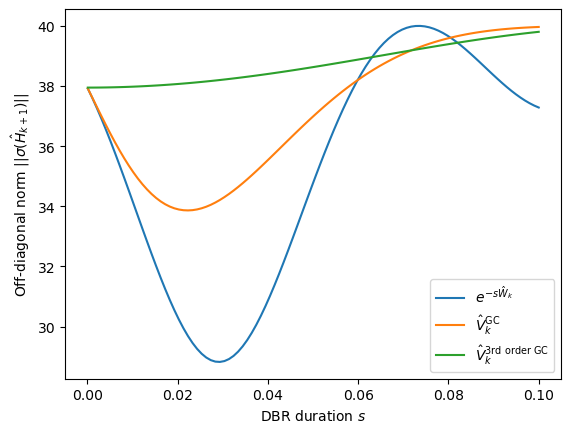

In [8]:
mode_names = [r'$e^{-s\hat W_k}$',
              r'$\hat V^{\text{GC}}_k$',
              r'$\hat V^{\text{3rd order GC}}_k$']
s_min = []
for i,mode in enumerate(modes):
    plt.plot(s_space, plots[i], label=mode_names[i])
    s_min.append(s_space[np.argmin(plots[i])])
# plt.xticks(s_min)
plt.ylabel(r'Off-diagonal norm $||\sigma(\hat H_{k+1})||$')
plt.xlabel(r'DBR duration $s$')
plt.legend()
plt.savefig('group_commutator.pdf')